<a href="https://colab.research.google.com/github/kanepickrell/memory-bridge/blob/main/memory_bridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import requests
import json
import pandas as pd
from google.colab import files

In [91]:
import requests

url = "https://raw.githubusercontent.com/kanepickrell/memory-bridge/main/MemoryFiles/MemoryFileV2.json"
response = requests.get(url)

if response.status_code == 200:
    try:
        data = response.json()  # Parse JSON
        print(data)
    except requests.exceptions.JSONDecodeError:
        print("Error: Response is not valid JSON")
        print(response.text)  # Print the response content to debug
else:
    print("Error fetching file:", response.status_code)

{'people': [{'id': 'p1', 'name': 'John Doe', 'age': 35, 'relationship': 'Friend', 'description': 'A long-time friend from college who enjoys hiking and photography.', 'tags': ['friend', 'college', 'hiking', 'photography'], 'recall_strength': 0.85}, {'id': 'p2', 'name': 'Jane Smith', 'age': 29, 'relationship': 'Sister', 'description': 'Younger sister who works as a software engineer.', 'tags': ['family', 'sister', 'tech'], 'recall_strength': 0.92}], 'events': [{'id': 'e1', 'date': '2023-07-15', 'related_people': [['p1', 0.9], ['p2', 0.8]], 'description': 'A hiking trip to the Grand Canyon with John and Jane.', 'tags': ['hiking', 'trip', 'adventure'], 'related_places': [['l1', 1.0]], 'recall_strength': 0.78}, {'id': 'e2', 'date': '2022-12-25', 'related_people': [['p2', 1.0]], 'description': "Christmas celebration at Jane's place.", 'tags': ['holiday', 'family', 'Christmas'], 'related_places': [['l2', 1.0]], 'recall_strength': 0.88}], 'locations': [{'id': 'l1', 'name': 'Grand Canyon', 'ad

In [92]:
df = pd.DataFrame(data)

In [93]:
df.head()

,people,events,locations
0,"{'id': 'p1', 'name': 'John Doe', 'age': 35, 'r...","{'id': 'e1', 'date': '2023-07-15', 'related_pe...","{'id': 'l1', 'name': 'Grand Canyon', 'address'..."
1,"{'id': 'p2', 'name': 'Jane Smith', 'age': 29, ...","{'id': 'e2', 'date': '2022-12-25', 'related_pe...","{'id': 'l2', 'name': 'Jane's Apartment', 'addr..."


In [94]:
df_normalized = pd.json_normalize(df['people'])

In [95]:
df_normalized.head()

,id,name,age,relationship,description,tags,recall_strength
0,p1,John Doe,35,Friend,A long-time friend from college who enjoys hik...,"[friend, college, hiking, photography]",0.85
1,p2,Jane Smith,29,Sister,Younger sister who works as a software engineer.,"[family, sister, tech]",0.92


In [57]:
df_normalized.columns

Index(['memory_id', 'type', 'date', 'description', 'tags', 'emotions',
       'associated_memories', 'duration', 'context.location', 'context.people',
       'context.event'],
      dtype='object')

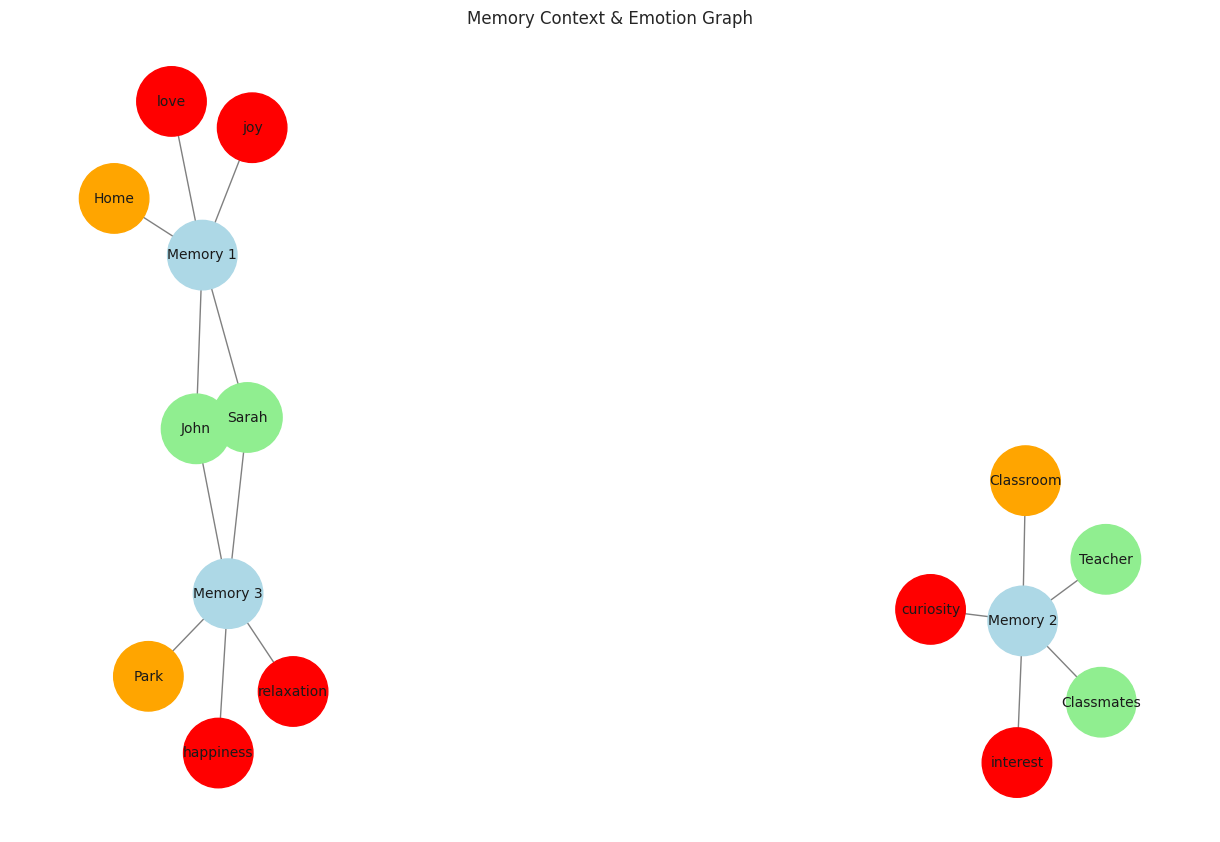

In [79]:
G2 = nx.Graph()

# add memory nodes
for _, row in df_normalized.iterrows():
    G2.add_node(f"Memory {row['memory_id']}", label=row['description'], color="lightblue")

# adding context nodes (location, people, emotions)
for _, row in df_normalized.iterrows():
    for person in row['context.people']:
        G2.add_node(person, color="lightgreen")
        G2.add_edge(f"Memory {row['memory_id']}", person)

    G2.add_node(row['context.location'], color="orange")
    G2.add_edge(f"Memory {row['memory_id']}", row['context.location'])

    ## event node may not make final cut
    for emotion in row['emotions']:
        G2.add_node(emotion, color="red")
        G2.add_edge(f"Memory {row['memory_id']}", emotion)

# visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G2)
node_colors = [G2.nodes[n].get("color", "gray") for n in G2.nodes]
nx.draw(G2, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=2500, font_size=10)

plt.title("Memory Context & Emotion Graph")
plt.show()

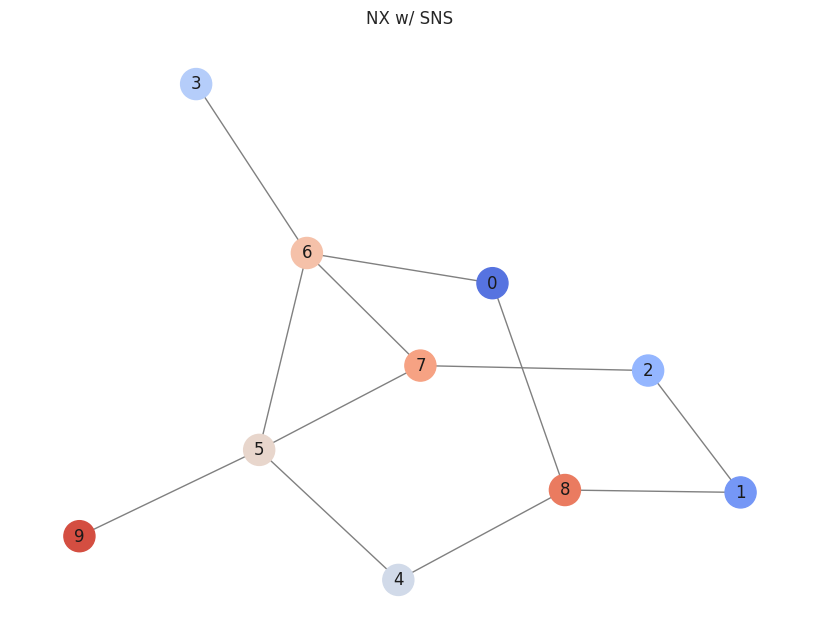

In [74]:
sns.set(style="whitegrid")
G = nx.erdos_renyi_graph(10, 0.3)  # Random graph with 10 nodes
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=sns.color_palette("coolwarm", 10), node_size=500, edge_color="gray")
plt.title("NX w/ SNS")
plt.show()